#  導入

このコンペティションはブラジルで3番目に大きな保険会社「PortoSegro」(https://en.wikipedia.org/wiki/Porto_Seguro_S.A.)によって、主催されていいる。

ここでは、次の年にドライバーが保険請求を開始する確率を予測することを求められている。

このノートでは、Pythonの可視化ライブラリPlotlyをつかって、インタラクティブなチャートと分析を与えることである。そして、いくつかの洞察と他人が理解し検証できるような、美しいグラフをもたらすことだ。Plotlyはソフトウェア会社Plotlyのメイン製品です。[Plotly](https://plot.ly/)
(##  Plotlyの説明が以下続く)


- 水平棒グラフ : 目的変数の分布を調査するのに使われる
- 相関ヒートマップ : 異なる特徴量同士の相関を調べるのに使われる。
- 散布図 : ランダムフォレストや勾配ブースティングによって生成された特徴量の重要性を比較する。
- 垂直棒グラフ : さまざまは変数の特徴量の重要性を並べたもの。
- 3D散布図

このノートでの要旨を手短にまとめると以下のようになる。

- データの質の確認 : 欠損値を評価し、可視化する。
- 特徴量の調査とふるい分け : 目的変数に対するそれぞれの情報同士の特徴量と相関のプロット。2値変数やカテゴリー変数やその他の変数の可視化。
- 学習モデルを通じた、重要な特徴量のランク付け。
　　　→ランダムフォレストや勾配ブースティングは学習プロセスによらない特徴量のランク付けをするのに役に立つ。
   
さあはじめよう。


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings("ignore")


In [2]:
train=pd.read_csv("train.csv")
train.head()


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
rows=train.shape[0]                 # 特にコメントなし
columns=train.shape[1]
print("The train dataset contains{0} rows and {1} columns".format(rows,columns))



The train dataset contains595212 rows and 59 columns


# データの質のチェック

## 欠損値の確認

我々のデータの質のチェックのセクションでは、trainデータセットに中にnullが含まれているかどうかを以下のようにしてみてみよう。

In [5]:
train.isnull().any().any()
#  any()　のデフォルトはaxis=0  なので、.any( ).any ( )で行方向にも列方向にも探査される。

False

nullが含まれるかどうかのチェックではFalseが返された。( ## ここの訳が不明。。。)
従って、PortoSegroが単純に、全てのnull値を-1で置き換えていたのであろうということにしよう。それでは、データの中のどこに欠損値があるのかどうか調べてみよう。

ここでは、どのカラムが-1の値をたくさんもっているか以下のように確認する。そのために、たとえば最初に全ての-1の値をnullで置き換えてみることが簡単である。

In [6]:
train_copy=train
train_copy=train_copy.replace(-1,np.NaN)



次に、Kagglerである、Aleksey BilogurのサイトからMissingnoとツールを使ってみよう。これは、データセットの中の欠損値を可視化するための便利で役にたつパッケージだ。早速やってみよう。

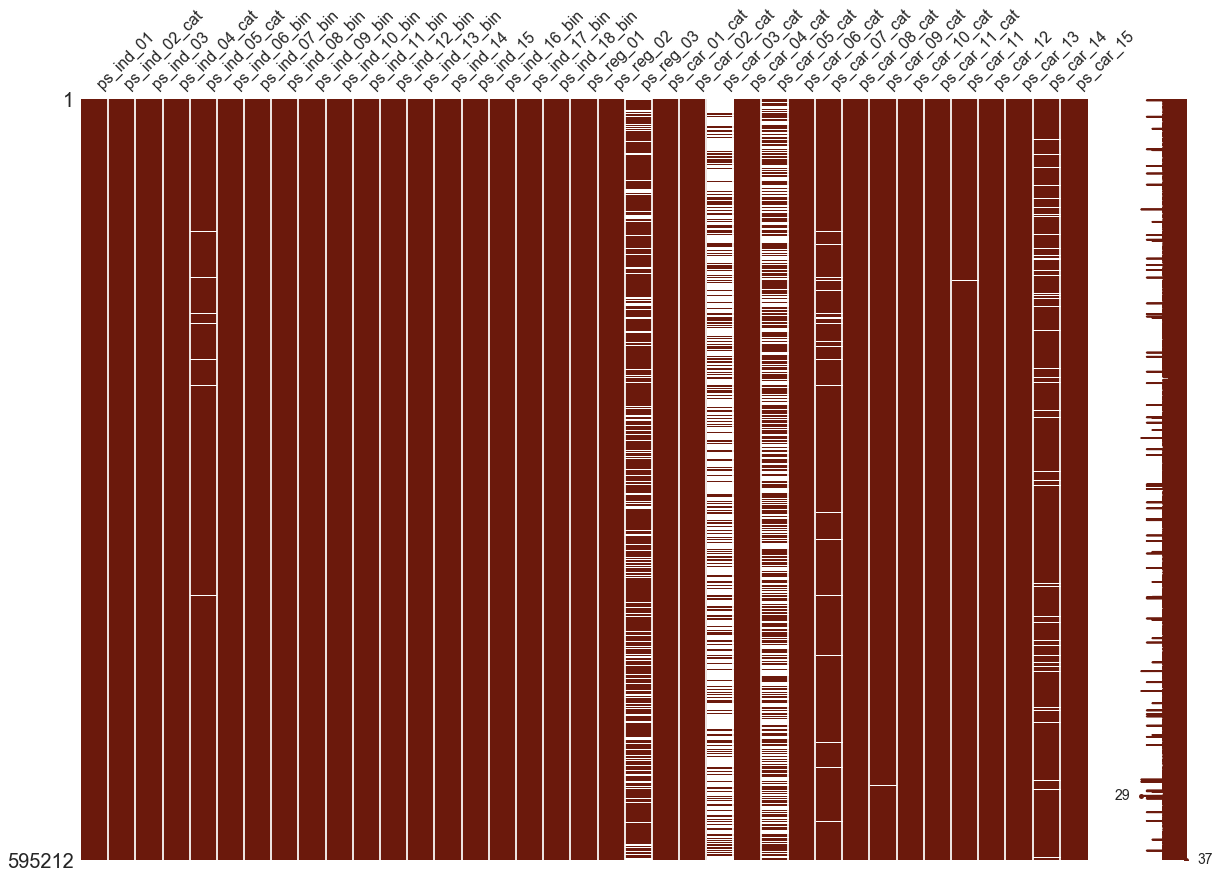

In [7]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2:39],figsize=(20,14),color=(0.42,0.1,0.05))


みればわかるように、可視化を行うことによって、欠損値がよりクリアになった。暗い赤の帯の上に載っている白の帯がそのカラムの欠損値を示している。
(##  このあとの訳ができない。。。)

ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14

ほとんどの欠損値は-.catで終わるカラムに含まれている。白や暗い赤の割合からわかるように、上記3つのカラムからはほとんどのデータが失われている。従って、-1の値をnullで置き換えるのは、必ずしもよい戦略とは言えないかもしれない。


## 目的変数の調査

その他の通常行われる確認は、今回のわれわれの目標変数については、親切なことに"target"と名前がついている。
(## このあとの訳が不明。。。)

In [8]:
data=[go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text = "Distribution of target variable"
)]



layout = go.Layout(
        title="Target variable distribution"
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename="basic-bar")



うーん。目標変数はややバランスがよくないので、気に留めておく必要がありそうだ。バランスのよくない変数はすぐに判明する。

# データ型の確認

この確認は、与えられたデータセットについてよりよく概観するために、そのデータセットがどんなデータ型から構成されているのかをみるために行う。pythonのシーケンスに含まれるデータ型を数え上げるうまい方法は、collectionメソッドをインポートしていれば、以下のようにしてCounterメソッドを使用する方法だ。

In [9]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

上記処理でほのめかされているように、trainデータセットを構成しているデータは59カラムあり、また今確認したように、特徴量カラムは二つのデータ型、int型とfloat型から構成されている。

もう一つ触れて触れておかなければならないのは、、Porto Segroは"_bin"や"_cat"、"_reg"といったように省略されたカラム名からなるヘッダーを提供しているということだ。それは、"_bin"という名前で2値からなる特徴量のデータということを示しており、一方で"_cat"という名前で、カテゴリー特徴量を表しており、またその他は連続値やオリジナルの特徴量を表している。ここでは、浮動小数点数型のデータ(おそらく、連続値から成る)や整数型データ(おそらく2値やカテゴリーデータや普通の特徴量を表す)をみることによって、これらのデータをより簡単にしていこう。


In [10]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

## 相関プロット

手始めとして、特徴量がどのような線型相関の関係にあるのかということをただみるために、線型相関のプロットを生成してみよう。そして、そこからなにか洞察を得てみよう。
ここで、相関係数のヒートマップを生成するために、seabornという統計可視化のライブラリを使ってみよう。便利なことに、pandasのDataFrameはピアソンの相関係数を計算するための、メソッド.corr()があらかじめ組み込まれている。また、seabornで相関プロットをする方法もまた便利だ。文字どおりのヒートマップだ。

## 浮動小数点数の特徴量の相関

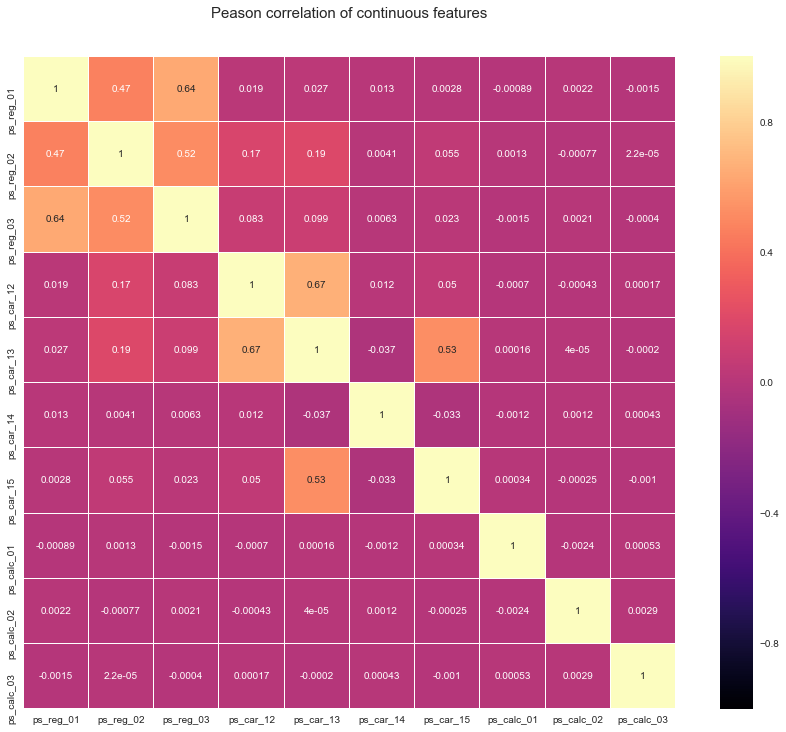

In [11]:
colormap = plt.cm.magma    # プロットするときに、グラデーション風にする色をテーマで選べる。
plt.figure(figsize=(16,12))
plt.title("Peason correlation of continuous features", y = 1.05, size =15)     #  表のタイトルは"ピアソン積率相関係数となっている。"
sns.heatmap(train_float.corr(), linewidths=0.1 , vmax=1.0,square=True,cmap=colormap,linecolor="white",annot=True)   
  #  DataFrame.corr() で計算される相関係数はデフォルトはピアソンの積率相関係数になる。
  # それ以外にもオプションを指定すれば、ケンドールの順位相関係数やスピアマンの順位相関係数なども求められる。


上記の相関プロットから、大半の特徴量のお互いの相関は0か、もしくは相関がないことを示している。これは以下でみていくような我々の調査が正しいということを示唆するとても興味深い結果だ。さて、上記の相関プロットで正の相関関係にあった特徴量のペアを挙げてみた。


- (ps_reg_01, ps_reg_03)

- (ps_reg_02, ps_reg_03)

- (ps_car_12, ps_car_13)

- (ps_car_13, ps_car_15)

##  整数型の特徴量の相関

整数型のデータのカラムに対しては、Plotlyというライブラリがどのように、動的な相関ヒートマップをつくるかみるために、Plotlyの使用に切り替えてみよう。(##  微妙に訳がわからない)
我々は、3つの座標軸を与えなければならない。xとyはカラムの名前で、相関係数はzで与えられる。(## このあとの訳がわからない。。。)



In [14]:
# train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)


data = [
    go.Heatmap(                                # goはplotlyの略称でした。
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
    #    text = True ,                      # text = True をいれるとエラーになる。試しにオリジナルのほうのコードを実行してみたが、それもエラー。
                                                   
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

同様に、相関プロット上に0値の相関係数がたくさんあることからもわかるように、お互いに線型な相関関係にはないカラムを観察することができる。これは、主成分分析などの次元削減などの変換を行おうとする場合には、とりわけ便利な結果だ。
以下のようなことが興味深いことを注意しておこう。

- 負に相関している特徴量 :  ps_ind_06_bin, ps_ind_07_bin,  ps_ind_08_bin,  ps_ind_09_bin

興味深い側面は、先ほどの欠損値に関する分析で、ps_car_03_catとps_car_05_catはたくさんの欠損値やnullを含んでいたことがわかった。従って、その分析に基づけば、それらの特徴量が強い正の相関関係を示すのは不思議ではないはずだ。にも関わらず、上記のヒートマップではその背景の真実を反映していないようだ。

# 相互情報量のプロット

相互情報量は、目的変数とそれに対して計算された特徴量の間の相互の情報量を調査することができる便利な道具だ。古典的な問題では、よくSklearnライブラリのmutual_info_classifというメソッドを使用する。それは、二つの確率変数の依存性を0から正の値の間の数値として測定できる。(0が確率変数が独立で、正の値のときは幾分か依存性がある)
従って、目的変数の情報はどのくらい特徴量の情報に含まれているのかを調べるのに役にたつ。
Sklearnのmutual_info_classif関数はk-近傍法によるエントロピー推定法をもとにしたノンパラメトリックの方法を使用している。それは、sklearnの公式ページをみればもっと詳しいことをしることができるだろう。

In [15]:
mf = mutual_info_classif(train_float.values,train.target.values,n_neighbors=3, random_state=17 )

#  相互情報量を計算している。そもそもの相互情報量とは、という部分については後回し。

print(mf)

[ 0.01402035  0.00431986  0.0055185   0.00778454  0.00157233  0.00197537
  0.01226     0.00553038  0.00545101  0.00562139]


## バイナリー特徴的の調査

我々が調査をしたいであろうもう一つの側面はバイナリーデータしか含んでいないカラムだろう。つまり、0か1しか取らないデータを含んでいるカラムだ。続けて、このようなカラムを記憶し、また以下のようにして垂直棒グラフを生成しよう。

In [16]:
# 各カラムの0の個数と1の個数の数え上げ。

bin_col = [col for col in train.columns if '_bin' in col]
#  データ型がバイナリーになっているカラムの名前を抽出。
#  リスト内包表記で、trainのカラム名の中で、"_bin"を含んでいるものだけを抽出。

zero_list = []
one_list = []
#このあとの処理で0の個数と1の個数を格納するためのリスト


for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())
    
#  bin_colの要素でfor文を回す。
#  (train[col]==0) の部分で、col列の各要素に対して0であればTrue、1であればFalseを返してリストにして返す。
#  True は1　としてみなされるので、(train[cols]==0).sum() でTrue　の部分だけの数えあげになる。
#   あるcol列に対して数えあげたら、zero_listに対してappend。　　それを全てのcol　にたいして回す。
#   one_listについても同様。
    


In [17]:
trace1 = go.Bar(
    x = bin_col,         # 横軸にカラムの名前。
    y = zero_list,      #  縦軸にそのカラムに含まれる0の個数
    name="Zero count"

)


trace2 = go.Bar(
    x = bin_col,           # 横軸にカラムの名前。
    y = one_list,         #  縦軸にそのカラムに含まれる1の個数
    name="One count"

)



data = [trace1 , trace2]          #  二つのグラフをまとめて一枚に表示
layout = go.Layout(
    barmode = "stack",              # いくつかオプションは指定できるが、stack式で。
    title = "Count of 1 and 0 in binary variables"
)


fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename="stacked-bar")



上記のように、4つの特徴をみてとれる。ps_ind_10_bin、ps_ind_11_bin、ps_ind_12_bin、ps_ind_13_bin はほとんど0で占められている。

これによって、これらの特徴量が他の対立する変数について十分な情報をもっておらず、役に立つのかどうかということに対しての疑問がとりあえず解決した。

# カテゴリー特徴量と順序特徴量の検査

それでは、末尾が"_cat"で終わっているカテゴリー特徴量のカラムに関してみていこう。

## ランダムフォレストを通した特徴量の重要性

さて、トレーニングデータをランダムフォレスト分類機に適用させるランダムフォレストモデルを実施してみよう。そしてモデルの訓練が終わった後、特徴量のランキングをみてみよう。これが、アンサンブルモデルを使うための近道だ。アンサンブルモデルは、特徴量の重要性についての有益な情報を引き出すのにパラメーターのチューニングに労力を必要とせず、また目標変数に対してもロバストだ。  (  ##  (　)の中の訳がわからない。。。)
アンサンブル学習を以下のようにして呼び出そう。

In [19]:
from sklearn.ensemble  import RandomForestClassifier
rf = RandomForestClassifier(n_estimators =150, max_depth=8,min_samples_leaf=4,max_features=0.2,n_jobs=-1 , random_state=0)
rf.fit(train.drop(["id","target"],axis=1),train.target)
features = train.drop(["id","target"],axis=1).columns.values
print("-----------Training Done--------------")


-----------Training Done--------------


# 特徴量の重要性のプロット

ランダムフォレストの学習が終わったので、特徴量の重要性に関するリストをfeature_importances_プロパティを使用することによって得ることができる。また次につかうplotlyplotの散布図にプロットもできる。

さて、Scatterというコマンドを実行してみよう。そして、以前のPlotly plotごとに対して、我々のx軸とy軸を定義する必要がある。しかし、散布図において気にしなければならないことの一つはマーカーの種類である。我々が決めるのは、また従って統制するサイズや色や散布図に埋め込む際のスケールがマーカーの属性である。

In [22]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

さらに、同じくPlotlyのbarplotを使って、重要度によってランク付けされ並び替えられた特徴量を重要度が高いほうから並べてみよう。

In [23]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

## 決定木の可視化

他のよく使われれ、興味がある仕掛けや技術は決定木モデルによって構築された木の可視化だろう。単純化するため、私は最大階層が3の決定木モデルを適用した。従って、3階層のみの決定木をみることになり、sklearnの"export_graphviz"を使用して可視化グラフをエクスポートして、このjupyternotebook上でインポートやエクスポートをするだろう。

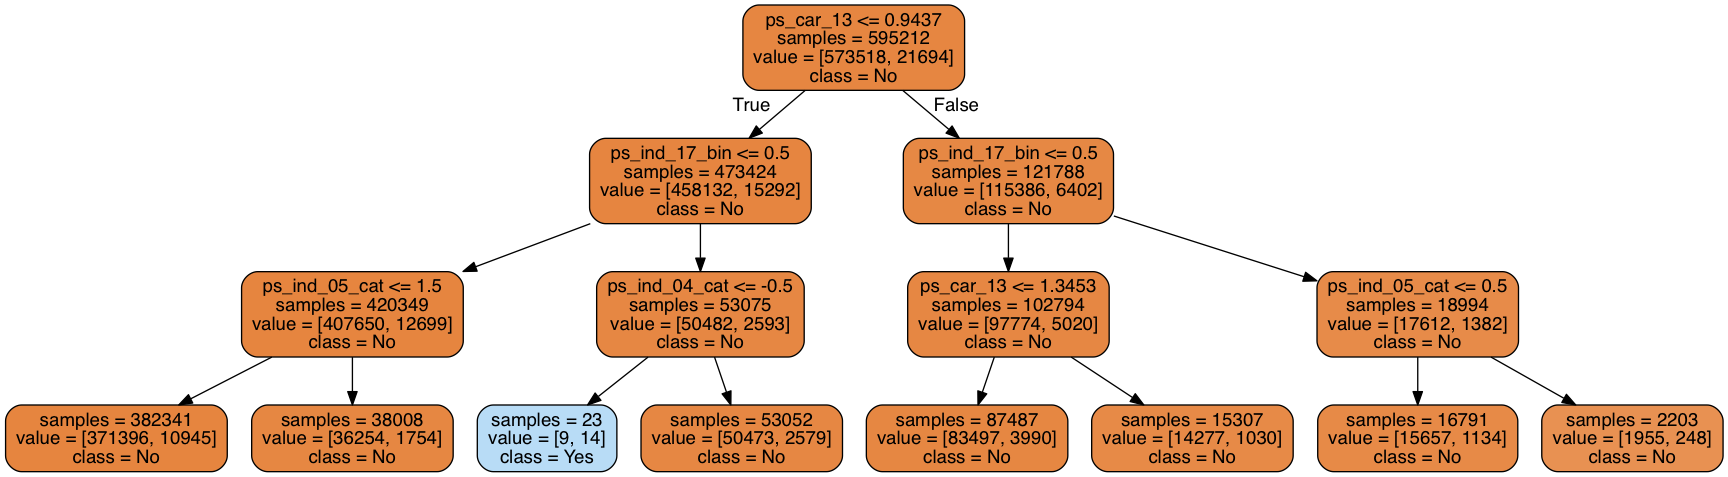

In [24]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

## 勾配ブーストモデルを用いた特徴量の重要性

興味本位ではあるが、我々の特徴量の重要性に関する情報を得るために、他の学習メソッドを使用してみよう。ここでは訓練データで学習するために勾配ブースティングを使用する。

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [4]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [5]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

面白いことに、ランダムフォレストも勾配ブースティングも最も重要な特徴量としてps_car_13を選びだした。

# 結論

PortoSegroのデータセットをつかって、広範囲にわたる、データの質や欠損値の調査を行ってみた。特徴量の線型相関だとか、特徴量の分布だとか、いくつかの学習モデルをそれが重要だと思う特徴量をあぶり出すためにしようしてみた。